# Regression diagnostics, confidence intervals. Multicollinearity. 
# Fitting non-linear models with linear regression. 
# Overfitting. Cross-validation. Regularization

## Regression diagnostics: Real estate prices in NYC

Recall recent example on real estate. All real estate sales accross NYC could be found on

https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

Again, consider data for Staten Island and try to model house price based on the house parameters

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
from sklearn import linear_model
import math
import seaborn as sbn
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
REStaten=pd.read_csv('data/rollingsales_statenisland.csv')

In [3]:
REStaten.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5391,65,,A3,22 BLUE HERON DRIVE,,...,1,0,1,8000,3000,1987,1,A3,1185000,3/19/18
1,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5395,19,,A1,4 EDWIN STREET,,...,1,0,1,7258,2230,1980,1,A1,866000,8/3/17
2,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5406,26,,A2,87 ELMBANK STREET,,...,1,0,1,5000,912,1950,1,A2,530000,4/27/18
3,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5407,10,,A2,112 ELMBANK STREET,,...,1,0,1,6242,1768,1975,1,A2,735000,11/7/17
4,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,6205,15,,A5,95 EAGAN AVENUE,,...,1,0,1,1546,1579,1986,1,A5,475000,9/7/17


In [4]:
REStaten.columns

Index([u'BOROUGH', u'NEIGHBORHOOD', u'BUILDING_CLASS_CATEGORY',
       u'TAX_CLASS_AT_PRESENT', u'BLOCK', u'LOT', u'EASE-MENT',
       u'BUILDING_CLASS_AT_PRESENT', u'ADDRESS', u'APARTMENT_NUMBER',
       u'ZIP_CODE', u'RESIDENTIAL_UNITS', u'COMMERCIAL_UNITS', u'TOTAL_UNITS',
       u'LAND_SQUARE_FEET', u'GROSS_SQUARE_FEET', u'YEAR_BUILT',
       u'TAX_CLASS_AT_TIME_OF_SALE', u'BUILDING_CLASS_AT_TIME_OF_SALE',
       u'SALE_PRICE', u'SALE_DATE'],
      dtype='object')

In [5]:
REStaten.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,8706.0,8706.000000,8706.000000,8706.000000,8706.000000,8706.000000,8706.000000,8.706000e+03,8706.000000,8706.000000,8706.000000,8.706000e+03
mean,5.0,3319.292212,208.871468,10132.832989,1.257179,0.062486,1.324144,5.016016e+03,1689.650930,1884.641282,1.171721,3.918813e+05
std,0.0,2344.202564,453.187678,1332.608872,1.579128,0.722336,1.718008,3.779630e+04,5804.911675,400.438263,0.601193,8.260853e+05
min,5.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00
25%,5.0,1116.000000,25.000000,10305.000000,1.000000,0.000000,1.000000,2.000000e+03,960.000000,1944.000000,1.000000,0.000000e+00
50%,5.0,3121.000000,56.000000,10308.000000,1.000000,0.000000,1.000000,3.125000e+03,1400.000000,1975.000000,1.000000,3.858250e+05
75%,5.0,5432.000000,135.000000,10312.000000,2.000000,0.000000,2.000000,4.520000e+03,1974.000000,1990.000000,1.000000,5.800000e+05
max,5.0,8050.000000,5359.000000,10314.000000,84.000000,43.000000,84.000000,3.014056e+06,349503.000000,2018.000000,4.000000,4.725000e+07


In [6]:
#as we see sale price and house size could be as low as zero. Exclude missing/unrealistic values by defining a reliable data index
#also take only houses with residential units
ind=(REStaten.SALE_PRICE>50000)&(REStaten.GROSS_SQUARE_FEET>300)&(REStaten.LAND_SQUARE_FEET>300)&(REStaten.RESIDENTIAL_UNITS>0)

In [7]:
#filter the data; loc accesses rows by boolean index (as opposed to integer positions done with iloc)
REStaten_=REStaten.loc[ind]

In [8]:
sfind=REStaten_.RESIDENTIAL_UNITS==1 #filter for the single family houses only

In [9]:
REStaten_sf=REStaten_.loc[sfind] #dataframe with single family houses

In [10]:
#bi-variate regression with an intercept of price vs size
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data = REStaten_sf).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     2560.
Date:                Wed, 26 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:20:26   Log-Likelihood:                -46831.
No. Observations:                3464   AIC:                         9.367e+04
Df Residuals:                    3462   BIC:                         9.368e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          1.949e+05   7213.38

Now let's pay attention to the statistics reported.

R2=0.425 - almost half of the variance explained (see the plot below for how this looks like), but definetely just size alone is not sufficient to fully determine the price.

We have an estimate of 214.95 for the price per sq.foot, but regression also return a standard error, confidence interval as well as the p-value for it. See some notices below.

### Uncertainty of regression estimates

While `coef` is what we care about in the first place (price per sq.foot), output reports multiple other quantities, such as standard error and confidence interval for this estimate.

We'll get to there exact meaning later, but for now just a rough idea: regression is a probabilistic model, admitting uncertainty in both - the data itself as well as the resulting model estimates. The data could be noisy, or represent just a partial available sample of observations or account for other parameters, not directly observed (i.e. market share of the considered mobile operators or special event happening in certain areas might affect mobile activity pushing it above or below a reasonable model expectation, making such observations the outliers, introducing noise and uncertainty).

But as we do not know which observations are the outliers, what if we run the regression multiple times on different samples of observations? Resulting values for the slope coefficient will form a certain distribution, as one can see below. This distribution will have not only the mean value, which will be consistent with the regression estimate reported above, but also **standard error** and **confidence intervals** (e.g. the interval where 95% most probable values belong) could be defined for it. 

This experiment is implemented below. By no means it explains the classic way of assessing uncertainty in regression estimates (and actually if you change the sampling fraction you'll see how it affects the standard deviation), but gives an idea of where such uncertainty might come from. We'll get to the rigorous definitions later over the course of the class, for now it is just important to understand the idea.

In [11]:
np.random.seed(2018)
W=[] #list for all the estimates
for i in range(0,100):
    df=REStaten_sf.sample(frac=0.85) #take a random 85% sample of observations
    lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data = df).fit() #run a regression on this sample
    W+=[lm.params.GROSS_SQUARE_FEET] #add the resulting coefficient to the list
W=np.array(W)
print 'w=%.4f+-%.4f'%(W.mean(), W.std()) #report an average as well as the standard deviation for the resulting values

w=214.7594+-4.2635


The **p-value** is roughly speaking - our degree of confidence that zero is the right value for the slope coefficient, i.e. that the given regressor is not essential for the model. It is defined by measuring the overall probability weight (or chance of occurance) of all values of the slope coefficient being no more likely than zero, according the probability distribution we obtain for them.

To better understand, consider a $t$-statistics standardizing the estimate $w^0=0$ for the coefficient in question using the regression estimate and its standard error
$$
t^0=\frac{w^0-\hat{w}}{\hat{\sigma}(w)}.
$$
and look at its distribution (t-distribution similar in shape to normal) below

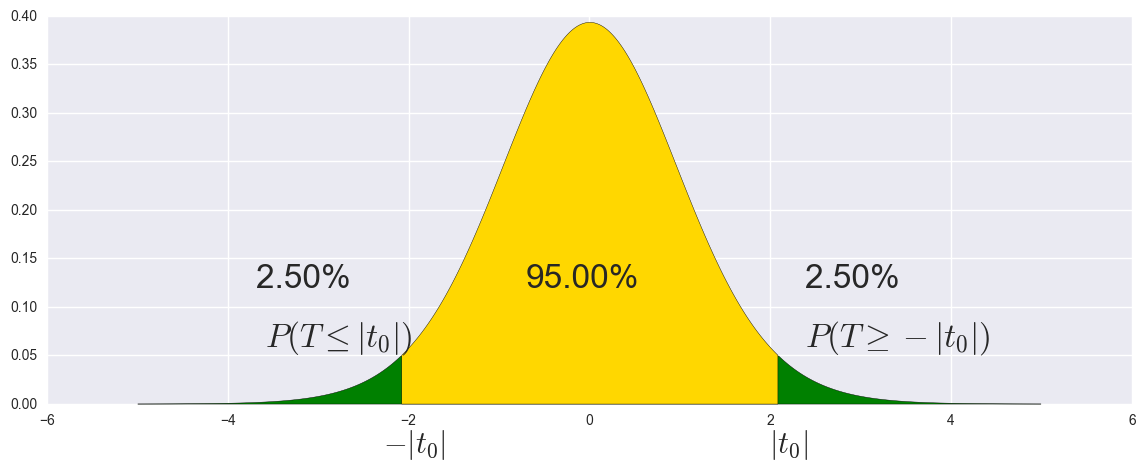

In [12]:
#an illustration below might give an idea
from scipy.stats import t
q = 0.05/2
df = 20    # degree of freedom
x = np.arange(-5,5,0.01)
y = t.pdf(x, df)    # default setting with location parameter 0 and scale parameter 1
t0 = t.ppf(q, df)   # lower bound
t1 = t.isf(q, df)   # upper bound, or simply "-t0" because of symmetry

ax = plt.figure(figsize=(14,5)).add_subplot(111)
ax.fill_between(x[(x<t0) | (x>t1)], 0, y[(x<t0) | (x>t1)], facecolor = 'green') # tails
ax.fill_between(x[(x>t0) & (x<t1)], 0, y[(x>t0) & (x<t1)], facecolor = 'gold')  # center
# Annotations
ax.text(t1+0.3,0.06,'$P(T\geq -|t_0|)$', fontsize = 24)
ax.text(t0-1.5,0.06,'$P(T\leq |t_0|)$', fontsize = 24)
ax.text(t1+0.3, 0.12, '%.2f%%'%(100*q), fontsize = 24)
ax.text(t0-1.6, 0.12, '%.2f%%'%(100*q), fontsize = 24)
ax.text(-0.7, 0.12, '%.2f%%'%(100*(1-q*2)), fontsize = 24)
ax.text(t0-0.2, -0.05, '$-|t_0|$', fontsize = 22)
ax.text(t1-0.1, -0.05, '$|t_0|$', fontsize = 22)
plt.show()

p-value reported above are neglectibly small showing that its hardly possible that 0 is the true value for the slope coefficient or intercept so we should reject such hypothesis 

In [13]:
lm.pvalues

Intercept            1.954931e-123
GROSS_SQUARE_FEET     0.000000e+00
dtype: float64

Now let's discuss the impact of multiple variables, which one might think relevant

In [14]:
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET+LAND_SQUARE_FEET+YEAR_BUILT', data = REStaten_sf).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     1404.
Date:                Wed, 26 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:20:27   Log-Likelihood:                -46410.
No. Observations:                3464   AIC:                         9.283e+04
Df Residuals:                    3460   BIC:                         9.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept         -2.081e+06   1.89e+0

### Excercise 1. Repeat this analysis for multi-family houses
First run regressions vs each GROSS_SQUARE_FEET, RESIDENTIAL_UNITS, LAND_SQUARE_FEET and then all together. What surprises you in the coefficients?